<a href="https://colab.research.google.com/github/LivingstonTardzenyuy/Deep-Learning-with-TensorFlow/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up(Food Vision mini)

We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).

The goal is to beat original Food101 paper with 10% of the trainig data using deep learning

In [1]:
!nvidia-smi

Fri Dec 27 03:24:56 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## creating helper functions.

In previous notebook, we've created a series of helper functions to do different tasks, let's download them.

In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py

--2024-12-27 03:24:58--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/refs/heads/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2024-12-27 03:24:58 (23.4 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import series of helper functions in notebook.

from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

our goal is to beat original Food101 paper with 10% of the trainig data using deep learning.

The data we're downloading comes from original Food101 dataset but has been processed using image_data_modifications notebook in github.


In [4]:

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")


train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2024-12-27 03:25:06--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  64.3MB/s    in 22s     

2024-12-27 03:25:28 (70.8 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [5]:
# How many image/classes are there ?.

walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/sashimi'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/macaroni_and_cheese'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/spaghetti_carbonara'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/shrimp_and_grits'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/edamame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/croque_madame'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/cheesecake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/prime_rib'.
There are 0 directories an

In [6]:
# Setup data inputs.

import tensorflow as tf

IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode='categorical',
                                                                                image_size = IMG_SIZE,)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode = "categorical",
                                                                image_size = IMG_SIZE,
                                                                shuffle=False # don't shuffle the test data for prediction analysis.
                                                                )


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes.

Here are the steps we're going to take:
* Create a ModelCheckpoint callback.
* Create a data augmentation layer to biuld data augmentation right into the model
* Build a headless(no top layer) efficientNetB0 backboned-model(we'll create our own layer)
* Compile our model
* Feature extract for 5 full passes


In [7]:
# Create a Checkpoint callback.

checkpoint_path = "101_classes_10_percent_data_model_checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only = True     # Save only the highest accuracy
                                                         )

In [8]:
  # Create data augmentation layer to incorporate it right into the model.
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      layers.RandomHeight(0.2),
      layers.RandomWidth(0.2),
      layers.RandomZoom(0.2),
      # layers.experimental.preprocessing.Rescaling(1/255.) # Skip this when using EfficientNetB0 bcause it is already build in. But for ResNet50 include it.
  ], name="data_augmentation")

 ## Model 1: Feature Extraction Transfer Learning with 10% of the data using Data Augmentation

In [9]:
# Setup input shpae and base model, freezing the base model layers.

input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(
    include_top=False
)
base_model.trainable = False

# Create input layer.
inputs = layers.Input(shape=input_shape, name="input_layer")

# Add in data augmentation sequential model as a layer.
x = data_augmentation(inputs)  # augment image

# Give the base model the inputs (after augmentation) and don't train it.
x = base_model(x, training=False)

# Pool out features of the base model.
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer.
outputs = layers.Dense(101, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ data_augmentation (Sequential)       │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, None, None, 1280)    │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_layer         │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 101)                 │         129,381 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,178,952 (15.94 MB)

 Trainable params: 129,381 (505.39 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [10]:
# Compile the model.
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ["accuracy"]
)

# Fit the model.
history_all_classes_10_percent = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = 5,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),   # Validate on 15% of the data during training
    callbacks = [checkpoint_callback]
)

Epoch 1/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 60s 195ms/step - accuracy: 0.1266 - loss: 4.0703 - val_accuracy: 0.3504 - val_loss: 2.8251
Epoch 2/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.4122 - loss: 2.6107 - val_accuracy: 0.3898 - val_loss: 2.3930
Epoch 3/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - accuracy: 0.4811 - loss: 2.2039 - val_accuracy: 0.5426 - val_loss: 1.8770
Epoch 4/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - accuracy: 0.5192 - loss: 1.9786 - val_accuracy: 0.5384 - val_loss: 1.8532
Epoch 5/5
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.5559 - loss: 1.8164 - val_accuracy: 0.5927 - val_loss: 1.6352


In [11]:
# Evaluate on the whole test dataset.
fine_tuning_results = model.evaluate(test_data)
fine_tuning_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5026 - loss: 1.9335


[1.8198206424713135, 0.5301781892776489]

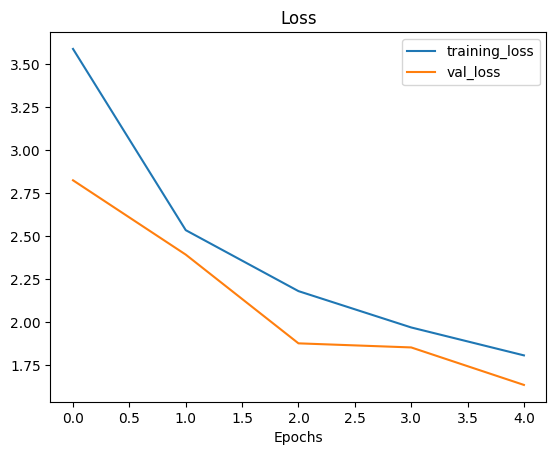

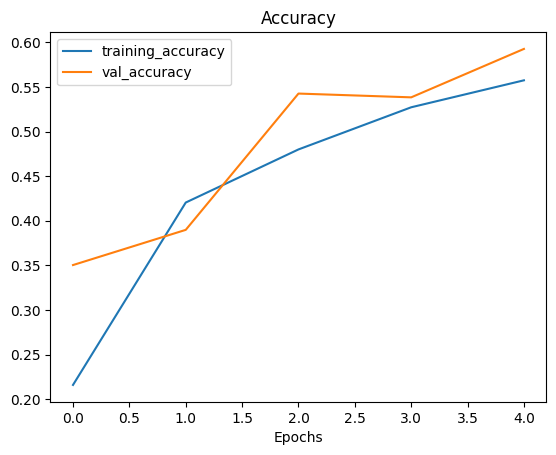

In [12]:
# Plot loss curves.

plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

In [13]:
# Unfreeze all of the layers in the base model

base_model.trainable = True

# Refreeze every layer except for the last 5.
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [14]:
# Recompile model with lower learning rate.....
model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ["accuracy"]
)

In [15]:
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling_layer True
output_layer True


In [16]:
 # Check which layers are trainable in our base model.
 for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_layer False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [17]:
# Fine-tune for more epochs.

fine_tune_epochs = 10  # we have done 5 epochs for feature extraction. let add another 5 for fine-tuning.

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(
    train_data_all_10_percent.repeat(),
    epochs = fine_tune_epochs,
    steps_per_epoch = len(train_data_all_10_percent),
    validation_data = test_data,
    validation_steps = int(0.15 * len(test_data)),
    initial_epoch = history_all_classes_10_percent.epoch[-1],   # Continue training where you finish in the feature extraction model.
    callbacks = [checkpoint_callback]
)

Epoch 5/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 54s 182ms/step - accuracy: 0.5646 - loss: 1.7834 - val_accuracy: 0.4981 - val_loss: 1.9711
Epoch 6/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 41s 174ms/step - accuracy: 0.6179 - loss: 1.5763 - val_accuracy: 0.5275 - val_loss: 1.7967
Epoch 7/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 169ms/step - accuracy: 0.6293 - loss: 1.4984 - val_accuracy: 0.5996 - val_loss: 1.5994
Epoch 8/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 167ms/step - accuracy: 0.6483 - loss: 1.4183 - val_accuracy: 0.5821 - val_loss: 1.6139
Epoch 9/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 39s 166ms/step - accuracy: 0.6738 - loss: 1.3306 - val_accuracy: 0.6178 - val_loss: 1.4799
Epoch 10/10
237/237 ━━━━━━━━━━━━━━━━━━━━ 40s 168ms/step - accuracy: 0.6858 - loss: 1.2839 - val_accuracy: 0.6126 - val_loss: 1.4177


In [18]:
# Evaluate oon the whole test dataset.
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 ━━━━━━━━━━━━━━━━━━━━ 60s 76ms/step - accuracy: 0.5483 - loss: 1.7162


[1.6115368604660034, 0.5739802122116089]

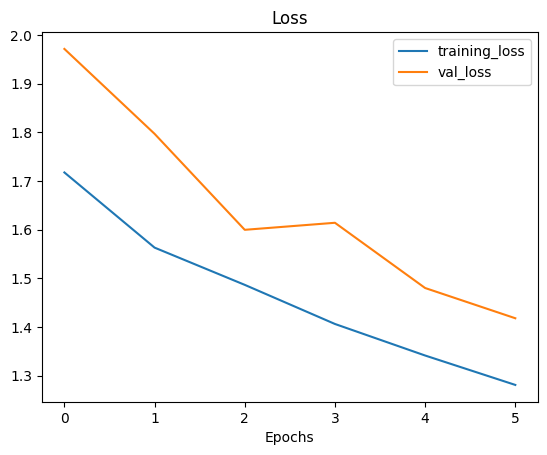

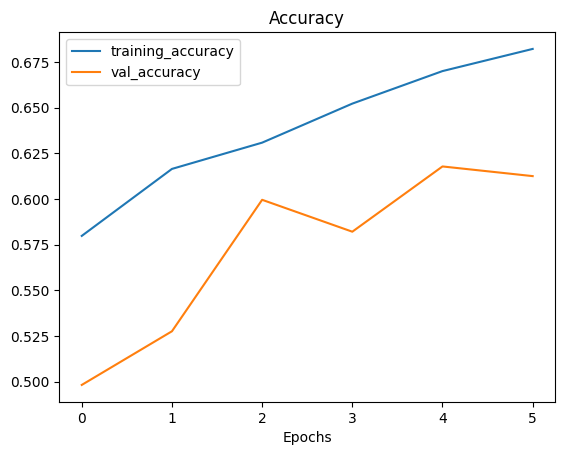

In [19]:
# plot loss curves.
plot_loss_curves(history_all_classes_10_percent_fine_tune)

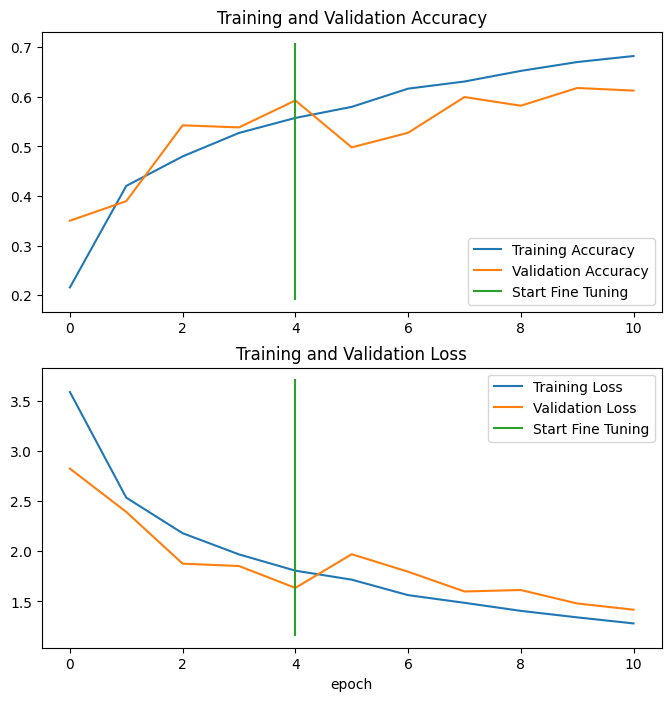

In [20]:
# Compare history of feature extraction model with fine-tuning model.
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune)

## Saving and loading our model.

To use our model in an external application, we'll need to save and load it somehow.

## Evaluating the performance of the big dog model across all different classes.

Let's make some predictions, visualize them and then later find out which predictions were the "most" wrong.

In [29]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip

--2024-12-27 03:49:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.188.207, 142.250.99.207, 142.250.107.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.188.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M  80.0MB/s    in 0.6s    

2024-12-27 03:49:12 (80.0 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [30]:
# Download pretrain model. one prepared earlier so all predictions are similar.
unzip_data('/content/06_101_food_class_10_percent_saved_big_dog_model.zip')

In [45]:
# # Load in save model
# from tensorflow.keras.layers import TFSMLayer
# from tensorflow import keras

# # model = TFSMLayer("/content/06_101_food_class_10_percent_saved_big_dog_model", call_endpoint='serving_default')
# # model

# model = keras.layers.TFSMLayer(
#     "/content/06_101_food_class_10_percent_saved_big_dog_model",
#     call_endpoint="serving_default",  # Change call_endpoint to 'serving_default'
# )

In [52]:
import tf_keras as k3

# Load in saved model.
model = k3.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model")
model

In [54]:
# Evaluate the loaded model.
results_downloaded_model = model.evaluate(test_data)
results_downloaded_model

790/790 [==============================] - 53s 67ms/step - loss: 1.8027 - accuracy: 0.6078


[1.8027204275131226, 0.6077623963356018]

 ## Making predictions with our trained model

In [55]:
# Make predictions with our model.

preds_probs = model.predict(test_data, verbose=1)  # to set verbosity to see how long is left
preds_probs

790/790 [==============================] - 57s 70ms/step


array([[5.95422126e-02, 3.57421368e-06, 4.13770415e-02, ...,
        1.41386758e-09, 8.35309620e-05, 3.08977091e-03],
       [9.64016795e-01, 1.37532197e-09, 8.47802090e-04, ...,
        5.42870985e-05, 7.83619176e-12, 9.84658355e-10],
       [9.59258795e-01, 3.25337751e-05, 1.48669642e-03, ...,
        7.18914123e-07, 5.43975830e-07, 4.02759288e-05],
       ...,
       [1.51387303e-05, 4.09730827e-04, 8.02506561e-10, ...,
        2.17428624e-05, 1.07971973e-05, 5.37898839e-01],
       [5.93179092e-03, 4.92364354e-03, 9.98231303e-03, ...,
        1.19894394e-04, 1.68902770e-05, 4.52179946e-02],
       [3.13634612e-02, 7.50525249e-03, 4.29750682e-04, ...,
        5.03464602e-04, 5.20561252e-06, 6.90628529e-01]], dtype=float32)

In [56]:
# What is shape of our predictions ?.
preds_probs.shape, len(test_data)

((25250, 101), 790)

In [57]:
# Let's see what the first 10 predictions look like.
preds_probs[:10]

array([[5.9542213e-02, 3.5742137e-06, 4.1377041e-02, ..., 1.4138676e-09,
        8.3530962e-05, 3.0897709e-03],
       [9.6401680e-01, 1.3753220e-09, 8.4780209e-04, ..., 5.4287098e-05,
        7.8361918e-12, 9.8465835e-10],
       [9.5925879e-01, 3.2533775e-05, 1.4866964e-03, ..., 7.1891412e-07,
        5.4397583e-07, 4.0275929e-05],
       ...,
       [4.7313288e-01, 1.2931191e-07, 1.4805571e-03, ..., 5.9750077e-04,
        6.6969005e-05, 2.3469400e-05],
       [4.4571895e-02, 4.7265519e-07, 1.2258518e-01, ..., 6.3498619e-06,
        7.5318503e-06, 3.6778899e-03],
       [7.2439003e-01, 1.9249673e-09, 5.2310970e-05, ..., 1.2291380e-03,
        1.5792693e-09, 9.6395343e-05]], dtype=float32)

In [60]:
# What does the first prediction probability look like.

preds_probs[0], len(preds_probs[0]), sum(preds_probs[0])

(array([5.95422126e-02, 3.57421368e-06, 4.13770415e-02, 1.06606324e-09,
        8.16142531e-09, 8.66396288e-09, 8.09274070e-07, 8.56529539e-07,
        1.98591606e-05, 8.09774235e-07, 3.17277338e-09, 9.86737973e-07,
        2.85322894e-04, 7.80490172e-10, 7.42304197e-04, 3.89164816e-05,
        6.47405386e-06, 2.49774143e-06, 3.78911900e-05, 2.06782616e-07,
        1.55384460e-05, 8.15073861e-07, 2.62306344e-06, 2.00106967e-07,
        8.38279050e-07, 5.42160706e-06, 3.73909870e-06, 1.31505775e-08,
        2.77615804e-03, 2.80519871e-05, 6.85621337e-10, 2.55748728e-05,
        1.66889717e-04, 7.64069696e-10, 4.04530176e-04, 1.31506805e-08,
        1.79573726e-06, 1.44482397e-06, 2.30628941e-02, 8.24670678e-07,
        8.53659003e-07, 1.71386728e-06, 7.05256207e-06, 1.84021616e-08,
        2.85534497e-07, 7.94839616e-06, 2.06815457e-06, 1.85251992e-07,
        3.36197594e-08, 3.15226032e-04, 1.04109295e-05, 8.54483289e-07,
        8.47418368e-01, 1.05554509e-05, 4.40948213e-07, 3.740417

Our model outputs a prediction probalility array (With N number of variables, where N is the number of classes) for each prediction.

In [61]:
# We get one prediction prob per class (in our case there's 101 prediction probaility per class)

print(f"Number of prediction probabilities for sample 0: {len(preds_probs[0])}")
print(f"What prediction probability sample 0 looks like:\n {preds_probs[0]}")
print(f"The class with the highest predicted probability by the model for sample 0: {preds_probs[0].argmax()}")

Number of prediction probabilities for sample 0: 101
What prediction probability sample 0 looks like:
 [5.95422126e-02 3.57421368e-06 4.13770415e-02 1.06606324e-09
 8.16142531e-09 8.66396288e-09 8.09274070e-07 8.56529539e-07
 1.98591606e-05 8.09774235e-07 3.17277338e-09 9.86737973e-07
 2.85322894e-04 7.80490172e-10 7.42304197e-04 3.89164816e-05
 6.47405386e-06 2.49774143e-06 3.78911900e-05 2.06782616e-07
 1.55384460e-05 8.15073861e-07 2.62306344e-06 2.00106967e-07
 8.38279050e-07 5.42160706e-06 3.73909870e-06 1.31505775e-08
 2.77615804e-03 2.80519871e-05 6.85621337e-10 2.55748728e-05
 1.66889717e-04 7.64069696e-10 4.04530176e-04 1.31506805e-08
 1.79573726e-06 1.44482397e-06 2.30628941e-02 8.24670678e-07
 8.53659003e-07 1.71386728e-06 7.05256207e-06 1.84021616e-08
 2.85534497e-07 7.94839616e-06 2.06815457e-06 1.85251992e-07
 3.36197594e-08 3.15226032e-04 1.04109295e-05 8.54483289e-07
 8.47418368e-01 1.05554509e-05 4.40948213e-07 3.74041701e-05
 3.53062496e-05 3.24890570e-05 6.73149116e-

In [64]:
# Get the pred classes of each label.
pred_classes = preds_probs.argmax(axis=1)

# How do they look ?.
pred_classes[:10]

array([52,  0,  0, 80, 79, 61, 29,  0, 85,  0])

In [66]:
# How many pred_clases do we have.
len(pred_classes)

25250

Now we got a predictions array of all of our models' prediction, to evaluate them we need to compare them to the original test dataset

In [68]:
# To get our test labels we need to unravel our test_data BatchDataset.

y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
  # print(images.shape, labels)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [69]:
# How many y_labels are ther ?.

len(y_labels)

25250

## Evalating our model's predictions.

one way to check that our model prediction's array is in the same order as our test labels array is. To find the accuracy score.

In [70]:
results_downloaded_model

[1.8027204275131226, 0.6077623963356018]

In [74]:
# Let's try sklearn accuracy score function and see what we have....

from sklearn.metrics import accuracy_score, confusion_matrix

sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.6077623762376237

In [72]:
# Does this metric come close to our model's evaluate results..
np.isclose(results_downloaded_model[1], sklearn_accuracy)

True

In [78]:
class_names = test_data.class_names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

sklearn_confusion_matrix = confusion_matrix(
    y_true = y_labels,
    y_pred = pred_classes,
    # labels = class_names
    )
plt.figure(figsize=(100,100))
sklearn_confusion_matrix
sns.heatmap(sklearn_confusion_matrix, annot=True)


<Axes: >